# Fraud Detection Model

## 1. Import Libraries

In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (roc_auc_score, average_precision_score, 
                             accuracy_score, f1_score, classification_report, confusion_matrix)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")


## 2. Load Data

In [5]:

df = pd.read_csv("Fraud.csv")


In [6]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [7]:
df.columns = [c.strip() for c in df.columns]
df["isFraud"] = df["isFraud"].astype(int)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## 3. Exploratory Data Analysis

In [8]:

print("Fraudulent transactions:", df["isFraud"].sum())
print("Fraud rate (%):", round(100*df["isFraud"].mean(), 4))


Fraudulent transactions: 8213
Fraud rate (%): 0.1291


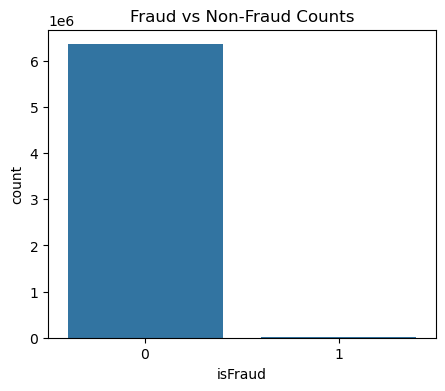

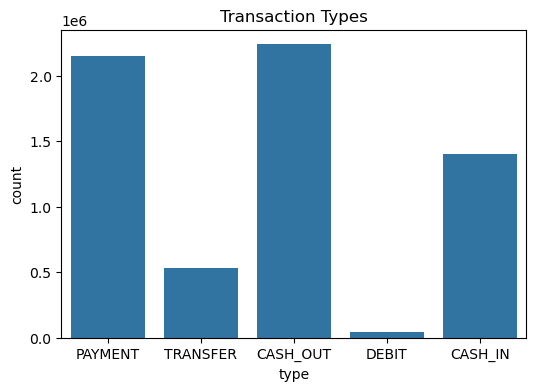

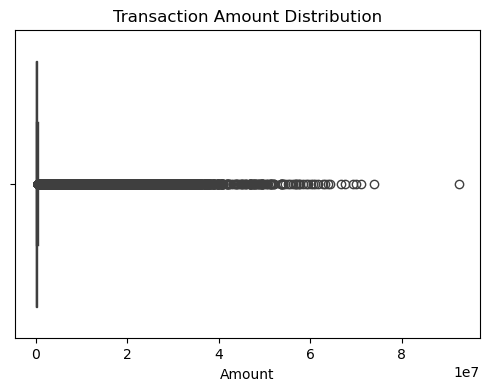

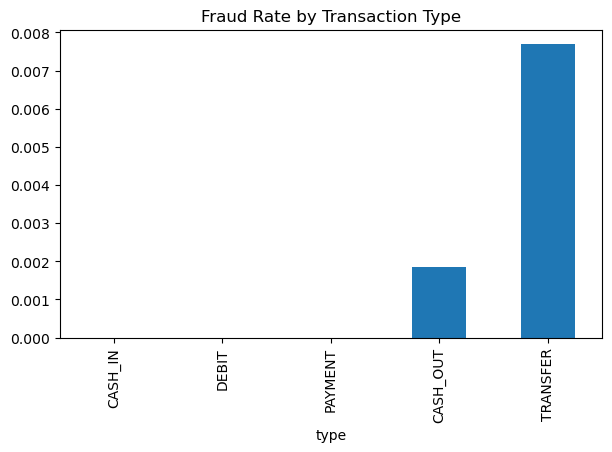

In [9]:
# Fraud class distribution
plt.figure(figsize=(5,4))
sns.countplot(x="isFraud", data=df)
plt.title("Fraud vs Non-Fraud Counts")
plt.show()

# Transaction type distribution
plt.figure(figsize=(6,4))
sns.countplot(x="type", data=df)
plt.title("Transaction Types")
plt.show()

# Transaction amount distribution 
plt.figure(figsize=(6,4))
sns.boxplot(x=df["amount"])
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.show()

# Fraud rate by transaction type
plt.figure(figsize=(7,4))
fraud_rate = df.groupby("type")["isFraud"].mean().sort_values()
fraud_rate.plot(kind="bar")
plt.title("Fraud Rate by Transaction Type")
plt.show()

## 4. Data Cleaning & Feature Engineering

In [10]:

# Negative balances -> NaN
num_cols = ["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"]
for c in num_cols:
    df.loc[df[c] < 0, c] = np.nan

# Outlier clipping for amount
amt_99 = df["amount"].quantile(0.999)
df["amount_clipped"] = np.minimum(df["amount"], amt_99)


In [11]:
# Feature engineering
df["orig_residual"] = df["oldbalanceOrg"].fillna(0) - df["amount"].fillna(0) - df["newbalanceOrig"].fillna(0)
df["dest_residual"] = df["oldbalanceDest"].fillna(0) + df["amount"].fillna(0) - df["newbalanceDest"].fillna(0)
df["log_amount"] = np.log1p(df["amount_clipped"].fillna(0))
df["isMerchantDest"] = df["nameDest"].astype(str).str.startswith("M").astype(int)

# Drop high-cardinality IDs
df = df.drop(columns=["nameOrig","nameDest"])

In [12]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,amount_clipped,orig_residual,dest_residual,log_amount,isMerchantDest
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0,9839.64,0.0,9839.64,9.194276,1
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0,1864.28,0.0,1864.28,7.531166,1
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0,181.00,0.0,181.00,5.204007,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0,181.00,0.0,21363.00,5.204007,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0,11668.14,0.0,11668.14,9.364703,1


## 5. Train-Test Split

In [13]:

X = df.drop(columns=["isFraud"])
y = df["isFraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


## 6. Preprocessing

In [14]:

numeric_features = ["step","amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest",
                    "newbalanceDest","orig_residual","dest_residual","log_amount","isFlaggedFraud","isMerchantDest"]
categorical_features = ["type"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)


## 7. Models

In [15]:

models = {
    "LogisticRegression": LogisticRegression(max_iter=200, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(class_weight="balanced", random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42)
}


## 8. Model Comparison

In [16]:

results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[("pre", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred_proba = pipe.predict_proba(X_test)[:, 1]
    y_pred = pipe.predict(X_test)
    
    results[name] = {
        "roc_auc": roc_auc_score(y_test, y_pred_proba),
        "pr_auc": average_precision_score(y_test, y_pred_proba),
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred)
    }

pd.DataFrame(results).T


,roc_auc,pr_auc,accuracy,f1
LogisticRegression,0.975695,0.539693,0.964761,0.060112
RandomForest,0.998782,0.997569,0.999997,0.998781
GradientBoosting,0.522469,0.491906,0.998968,0.364780
XGBoost,0.998596,0.996513,0.999969,0.988149


## 9. Model Selection & Hyperparameter Tuning

In [17]:

best_model_name = max(results, key=lambda x: results[x]["pr_auc"])
print("Best model:", best_model_name)

param_grid = {}
if best_model_name == "RandomForest":
    param_grid = {
        "model__n_estimators": [100, 200, 300],
        "model__max_depth": [5, 10, None],
        "model__min_samples_leaf": [1, 5, 10]
    }
elif best_model_name == "XGBoost":
    param_grid = {
        "model__max_depth": [3, 6, 10],
        "model__learning_rate": [0.01, 0.1, 0.2],
        "model__n_estimators": [100, 200, 500]
    }
elif best_model_name == "GradientBoosting":
    param_grid = {
        "model__learning_rate": [0.01, 0.1, 0.2],
        "model__n_estimators": [100, 200, 500],
        "model__max_depth": [3, 5, 7]
    }

pipe = Pipeline(steps=[("pre", preprocessor), ("model", models[best_model_name])])

search = RandomizedSearchCV(pipe, param_distributions=param_grid, 
                            n_iter=5, cv=3, scoring="average_precision", 
                            verbose=2, n_jobs=-1, random_state=42)

search.fit(X_train, y_train)

print("Best Parameters:", search.best_params_)
y_pred = search.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Best model: RandomForest
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters: {'model__n_estimators': 200, 'model__min_samples_leaf': 5, 'model__max_depth': 10}

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       1.00      1.00      1.00      1643

    accuracy                           1.00   1272524
   macro avg       1.00      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion Matrix:
 [[1270881       0]
 [      4    1639]]


In [18]:
# 4. Save Final Model
import joblib
joblib.dump(search.best_estimator_, "fraud_model.pkl")
print("✅ Final tuned model saved as fraud_model.pkl")

✅ Final tuned model saved as fraud_model.pkl


In [19]:
import sklearn
print(sklearn.__version__)


1.5.1
